# Vegetation Phenology <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

* **Products used:** 
[s2_l2a](https://explorer.digitalearth.africa/s2_l2a)


## Background
Phenology is the study of plant and animal life cycles in the context of the seasons.
It can be useful in understanding the life cycle trends of crops and how the growing seasons are affected by changes in climate.
For more information, see the [USGS page on deriving phenology from NDVI time-series](https://www.usgs.gov/land-resources/eros/phenology/science/deriving-phenological-metrics-ndvi?qt-science_center_objects=0#qt-science_center_objects)

## Description

This notebook demonstrates how to calculate vegetation phenology statistics using the DE Africa function [xr_phenology](../Scripts/deafrica_temporal_statistics.py).  To detect changes in plant life for Sentinel-2, the script uses either the **Normalized Difference Vegetation Index (NDVI)** or the **Enhanced Vegetation Index (EVI)**, which are common proxies for vegetation growth and health.

The outputs of this notebook can be used to assess spatio-temporal differences in the growing seasons of agriculture fields or native vegetation.

This notebook demonstrates the following steps:

1. Load cloud-masked Sentinel 2 data for an area of interest.
2. Calculate a vegetation proxy index (NDVI or EVI).
3. Generate a zonal time series of vegetation health
4. Complete and smooth the vegetation timeseries to remove gaps and noise.
5. Calculate phenology statistics on a simple 1D vegetation time series
6. Calculate per-pixel phenology statistics
7. Optional: Calculating generic temporal statistics usng the hdstats library

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Load key Python packages and supporting functions for the analysis.

In [1]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import xarray as xr
import datetime as dt
import os

sys.path.append('../Scripts')
from deafrica_datahandling import load_ard
from deafrica_bandindices import calculate_indices
from deafrica_plotting import display_map, rgb
import deafrica_temporal_statistics as ts
from deafrica_dask import create_local_dask_cluster

from datacube.utils.aws import configure_s3_access
configure_s3_access(aws_unsigned=True, cloud_defaults=True)


/env/lib/python3.6/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:33747 Dashboard: /user/chad/proxy/8787/status,Cluster Workers: 1 Cores: 15 Memory: 104.37 GB


### Connect to the datacube

Connect to the datacube so we can access DE Africa data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [3]:
dc = datacube.Datacube(app='Vegetation_phenology')

### Analysis parameters

The following cell sets important parameters for the analysis:

* `veg_proxy`: Band index to use as a proxy for vegetation health e.g. `'NDVI'` or `'EVI'`
* `lat`: The central latitude to analyse (e.g. `-10.6996`).
* `lon`: The central longitude to analyse (e.g. `35.2708`).
* `buffer`: The number of square degrees to load around the central latitude and longitude.
For reasonable loading times, set this as `0.1` or lower.
* `time_range`: The year range to analyse (e.g. `('2019-01', '2019-06')`).



In [4]:
# Set the vegetation proxy to use
veg_proxy = 'EVI'

# Define area of interest
lat = 0.6530 
lon = 36.161
lon_buffer = 0.1
lat_buffer = 0.1

# Set the range of dates for the analysis
time_range = ('2018-01', '2018-12')

In [5]:
# Combine central lat,lon with buffer to get area of interest
lat_range = (lat-lat_buffer, lat+lat_buffer)
lon_range = (lon-lon_buffer, lon+lon_buffer)

## View the selected location
The next cell will display the selected area on an interactive map.
Feel free to zoom in and out to get a better understanding of the area you'll be analysing.
Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [16]:
display_map(x=lon_range, y=lat_range)

## Load cloud-masked Sentinel-2 data

The first step is to load Sentinel-2 data for the specified area of interest and time range. 
The `load_ard` function is used here to load data that has been masked for cloud, shadow and quality filters, making it ready for analysis.

In [6]:
# Create a reusable query
query = {
    'y': lat_range,
    'x': lon_range,
    'time': time_range,
    'measurements': ['red', 'green', 'blue', 'nir', 'swir_1', 'SCL'],
    'resolution': (-10, 10),
    'output_crs': 'epsg:6933',
    'group_by':'solar_day'
}

# Load available data from Landsat 8
ds = load_ard(
    dc=dc,
    products=['s2_l2a'],
    dask_chunks={'x':750, 'y':750},
    min_gooddata=0.15,
    **query,
)

print(ds)

../Scripts/deafrica_datahandling.py:240: UserWarning: Setting 'min_gooddata' percentage to > 0.0 will cause dask arrays to compute when loading pixel-quality data to calculate 'good pixel' percentage. This can slow the return of your dataset.
  warnings.warn("Setting 'min_gooddata' percentage to > 0.0 "


Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Counting good quality pixels for each time step
Filtering to 63 out of 73 time steps with at least 15.0% good quality pixels
Applying pixel quality/cloud mask
Returning 63 time steps as a dask array
<xarray.Dataset>
Dimensions:      (time: 63, x: 1930, y: 2552)
Coordinates:
  * time         (time) datetime64[ns] 2018-01-02T08:07:58 ... 2018-12-28T08:...
  * y            (y) float64 9.606e+04 9.604e+04 ... 7.056e+04 7.054e+04
  * x            (x) float64 3.479e+06 3.479e+06 ... 3.499e+06 3.499e+06
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) float32 dask.array<chunksize=(1, 750, 750), meta=np.ndarray>
    green        (time, y, x) float32 dask.array<chunksize=(1, 750, 750), meta=np.ndarray>
    blue         (time, y, x) float32 dask.array<chunksize=(1, 750, 750), meta=np.ndarray>
    nir          (time, y, x) float32 dask.array<chunksize=(1, 750, 750), meta=np.ndarray>
    swir_1      

## Cloud Buffering

Not sure how this works yet so commented out for now

In [ ]:
# import odc.algo

# #Extract boolean mask
# mask = odc.algo.enum_to_bool(ds.SCL, 
#                              categories=['cloud shadows', 'cloud medium probability',
#                                          'cloud high probability', 'thin cirrus'])
                             
# # Close mask to remove small holes in cloud, open mask to 
# # remove narrow false positive cloud, then dilate
# mask = odc.algo.binary_closing(mask, 2)
# mask_cleaned = odc.algo.mask_cleanup(mask, r=(10, 10))

# # Add new mask as nodata pixels
# ds = odc.algo.erase_bad(ds, mask_cleaned)


## Compute band indices, and clean up data

In [7]:
# Calculate the chosen vegetation proxy index and add it to the loaded data set
ds = calculate_indices(ds, index=['EVI', 'MNDWI'], collection='s2')

# remove any infinite values
ds = ds.where(xr.ufuncs.isfinite(ds))

# mask water
ds = ds.where(ds.MNDWI < 0)

#remove outliers (if EVI greater than 1.0, set to NaN) 
ds['EVI'] = xr.where(ds['EVI']>1.0, np.nan, ds['EVI'])

# persist EVI data on the cluster (will speed up calcs later on)
ds['EVI'] = ds['EVI'].persist()

**Once the load is complete**, we can plot some of the images as as a true-colour image using the `rgb` function.  

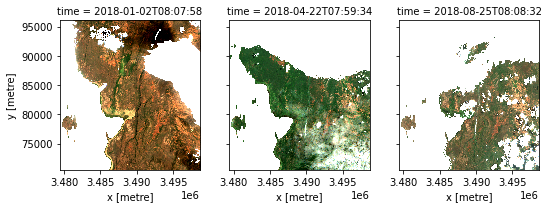

In [8]:
rgb(ds, index=[0,20,40], col_wrap=3, size=3)

The vegetation proxy index should now appear as a data variable, along with the loaded measurements, in the `ds` object.

## Plot the vegetation index over time

To get an idea of how the vegetation health changes throughout the year(s), we can plot a zonal time series over the region of interest. First we will do a simple plot of the zonal mean of the data.  


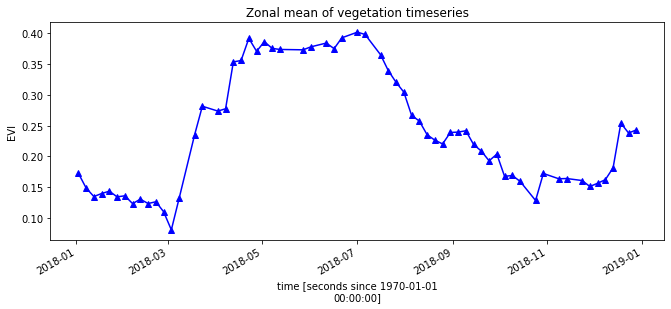

In [9]:
ds.EVI.mean(['x', 'y']).plot.line('b-^', figsize=(11,4))
plt.title('Zonal mean of vegetation timeseries');

### Zonal phenology statistics

To help us understand what these statistics refer too, lets first pass the simpler zonal mean (mean of all pixels in the image) time-series to the function and plot the results on the same curves as above.

In [10]:
#calculate phenology on the zonal mean of the dataset
zonal_phen = ts.xr_phenology(
        ds.EVI.mean(['x', 'y']),
        stats=['SOS', 'POS', 'EOS', 'vSOS', 'vPOS', 'vEOS'],
        method_sos="median",
        method_eos="median",
        complete="linear",
        smoothing="rolling_mean").compute()

print(zonal_phen)

<xarray.Dataset>
Dimensions:      ()
Coordinates:
    spatial_ref  int32 6933
Data variables:
    SOS          int16 82
    POS          int16 187
    EOS          int16 262
    vSOS         float32 0.21612081
    vPOS         float32 0.39686817
    vEOS         float32 0.22326738


Plot the results with our statistcs annotated on the plot

First need to generate a time-series that matches the parameters set in the phenology calculation above

In [11]:
evi_rolling = ds.EVI.mean(['x', 'y']).rolling(time=3, min_periods=1).mean().compute()

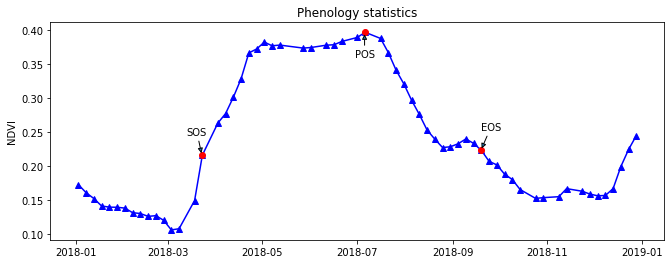

In [12]:
# Use DOY results to create a datetime object
year = str(ds.time.dt.year.values[0]) + " "
eos_dt = dt.datetime.strptime(year + str(zonal_phen.EOS.values), '%Y %j')
sos_dt = dt.datetime.strptime(year + str(zonal_phen.SOS.values), '%Y %j')
pos_dt = dt.datetime.strptime(year + str(zonal_phen.POS.values), '%Y %j')

#create plot
fig, ax = plt.subplots(figsize=(11, 4))

ax.plot(evi_rolling.time, evi_rolling, 'b-^')

#add start of season
ax.plot(sos_dt, zonal_phen.vSOS, 'or')
ax.annotate('SOS',
            xy=(sos_dt, zonal_phen.vSOS.values),
            xytext=(-15, 20),
            textcoords='offset points',
            arrowprops=dict(arrowstyle='-|>'))

#add end of season
ax.plot(eos_dt, zonal_phen.vEOS, 'or')
ax.annotate('EOS',
            xy=(eos_dt, zonal_phen.vEOS.values),
            xytext=(0, 20),
            textcoords='offset points',
            arrowprops=dict(arrowstyle='-|>'))

#add peak of season
ax.plot(pos_dt, zonal_phen.vPOS, 'or')
ax.annotate('POS',
            xy=(pos_dt, zonal_phen.vPOS.values),
            xytext=(-10, -25),
            textcoords='offset points',
            arrowprops=dict(arrowstyle='-|>'))

plt.ylabel('NDVI')
plt.title('Phenology statistics');

### Per-pixel phenology statistics

We can now calculate the statistics for every pixel in our time-series and plot the results. In the code below we have changed the `method_eos` and `method_sos` parameters to `'median'`, this will estimate the beginning and end of the growing seasons as the median value of the slopes on the each side of the curve. The code below also demonstrates using the `fast_complete` and `wiener` methods for gap-filling and smoothing.

In [13]:
#calculate phenology stats on every pixel in dataset
phen = ts.xr_phenology(
        ds.EVI,
        method_sos='median',
        method_eos='median',
        complete='linear',
        smoothing='rolling_mean'
    ).compute()

print(phen)

<xarray.Dataset>
Dimensions:      (x: 1930, y: 2552)
Coordinates:
  * y            (y) float64 9.606e+04 9.604e+04 ... 7.056e+04 7.054e+04
  * x            (x) float64 3.479e+06 3.479e+06 ... 3.499e+06 3.499e+06
    spatial_ref  int32 0
Data variables:
    SOS          (y, x) int16 12 17 17 27 67 62 27 97 ... 22 22 22 22 22 17 82
    POS          (y, x) int16 127 127 122 122 132 127 ... 147 147 147 182 187
    EOS          (y, x) int16 242 232 267 232 262 262 ... 312 267 267 242 317
    Trough       (y, x) float32 0.07375248 0.054220133 ... 0.10541869 0.09318753
    vSOS         (y, x) float32 0.117995664 0.08556862 ... 0.20734815 0.2376965
    vPOS         (y, x) float32 0.495939 0.4293928 ... 0.5968403 0.6213076
    vEOS         (y, x) float32 0.26359886 0.18130748 ... 0.37854457 0.31920585
    LOS          (y, x) int16 230 215 250 205 195 200 ... 290 245 245 225 235
    AOS          (y, x) float32 0.4221865 0.37517267 ... 0.49142164 0.5281201
    ROG          (y, x) float32 0.003286

The phenology statistics have been calculated seperately for every pixel in the image.  Let's plot each of them to see the results. 

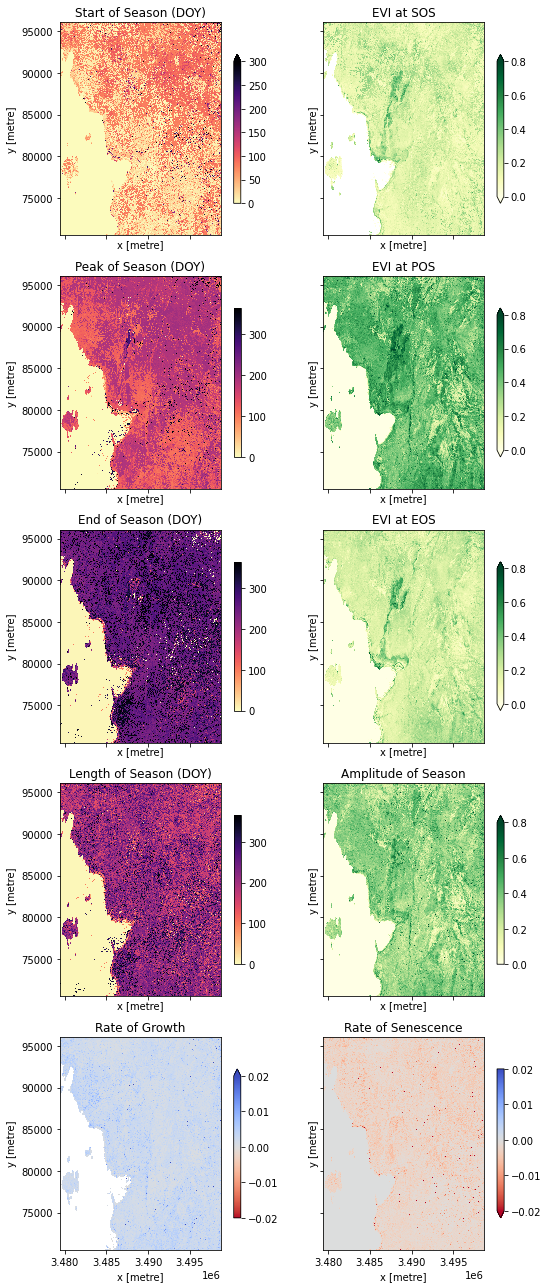

In [14]:
# set up figure
fig, ax = plt.subplots(nrows=5,
                       ncols=2,
                       figsize=(8, 18),
                       sharex=True,
                       sharey=True)

# set colorbar size
cbar_size = 0.7

# set aspect ratios
for a in fig.axes:
    a.set_aspect('equal')

# start of season
phen.SOS.plot(ax=ax[0, 0],
              cmap='magma_r',
              vmax=300,
              vmin=0,
              cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[0, 0].set_title('Start of Season (DOY)')
phen.vSOS.plot(ax=ax[0, 1],
               cmap='YlGn',
               vmax=0.8,
               vmin=0,
               cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[0, 1].set_title(veg_proxy+' at SOS')

# peak of season
phen.POS.plot(ax=ax[1, 0],
              cmap='magma_r',
              vmax=365,
              vmin=0,
              cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[1, 0].set_title('Peak of Season (DOY)')
phen.vPOS.plot(ax=ax[1, 1],
               cmap='YlGn',
               vmax=0.8,
               vmin=0,
               cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[1, 1].set_title(veg_proxy+' at POS')

# end of season
phen.EOS.plot(ax=ax[2, 0],
              cmap='magma_r',
              vmax=365,
              vmin=0,
              cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[2, 0].set_title('End of Season (DOY)')
phen.vEOS.plot(ax=ax[2, 1],
               cmap='YlGn',
               vmax=0.8,
               vmin=0,
               cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[2, 1].set_title(veg_proxy+' at EOS')

# Length of Season
phen.LOS.plot(ax=ax[3, 0],
              cmap='magma_r',
              vmax=365,
              vmin=0,
              cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[3, 0].set_title('Length of Season (DOY)')

# Amplitude
phen.AOS.plot(ax=ax[3, 1],
              cmap='YlGn',
              vmax=0.8,
              cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[3, 1].set_title('Amplitude of Season')

# rate of growth
phen.ROG.plot(ax=ax[4, 0],
              cmap='coolwarm_r',
              vmin=-0.02,
              vmax=0.02,
              cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[4, 0].set_title('Rate of Growth')

# rate of Sensescence
phen.ROS.plot(ax=ax[4, 1],
              cmap='coolwarm_r',
              vmin=-0.02,
              vmax=0.02,
              cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[4, 1].set_title('Rate of Senescence')

plt.tight_layout();

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** September 2020

**Compatible datacube version:** 

In [15]:
print(datacube.__version__)

1.8.4.dev52+g07bc51a5


## Tags
Browse all available tags on the DE Africa User Guide's [Tags Index](https://) (placeholder as this does not exist yet)